# 2. Analysis

This part is an analysis of the data that is produced by the simulation notebook. We should be able to generate a model that can predict the distance from the source according to different metrics.

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping


from pickle import dump
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization

import os

Since the data is stored in a CSV file, we can use the pandas library to load the data and analyze it.

In [142]:
data = pd.read_csv('data.csv')

Let's shows few caracteristics of the data:

1. 5 first rows

In [143]:
data.head()

,diffusion_coefficients,x,y,time,values,distances_to_source,relative_offsets,source_positions_x,source_positions_y
0,0.1,5.2,5.2,0.0,0.000000,0.282843,0.0,5.0,5.0
1,0.1,5.2,5.2,0.1,0.000250,0.282843,0.0,5.0,5.0
2,0.1,5.2,5.2,0.2,0.000925,0.282843,0.0,5.0,5.0
3,0.1,5.2,5.2,0.3,0.002142,0.282843,0.0,5.0,5.0
4,0.1,5.2,5.2,0.4,0.003973,0.282843,0.0,5.0,5.0


2. Data description

In [144]:
data.describe()

,diffusion_coefficients,x,y,time,values,distances_to_source,relative_offsets,source_positions_x,source_positions_y
count,4.099400e+06,4.099400e+06,4.099400e+06,4.099400e+06,4.099400e+06,4.099400e+06,4.099400e+06,4.099400e+06,4.099400e+06
mean,5.500000e-01,1.202913e+01,9.631650e+00,9.900000e+00,7.474133e-03,9.384092e+00,-8.984840e+01,8.262136e+00,1.176214e+01
std,2.731397e-01,4.784710e+00,5.229392e+00,5.744563e+00,3.643899e-02,5.454782e+00,2.288431e+01,3.196893e+00,3.193094e+00
min,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.414214e-01,-1.980000e+02,5.000000e+00,5.000000e+00
25%,3.250000e-01,8.800000e+00,5.400000e+00,4.900000e+00,0.000000e+00,4.750789e+00,-9.700000e+01,5.000000e+00,1.000000e+01
50%,5.500000e-01,1.220000e+01,1.000000e+01,9.900000e+00,6.164946e-28,9.308598e+00,-9.500000e+01,7.500000e+00,1.250000e+01
75%,7.750000e-01,1.600000e+01,1.340000e+01,1.490000e+01,3.203223e-08,1.385929e+01,-9.000000e+01,1.000000e+01,1.500000e+01
max,1.000000e+00,1.980000e+01,1.980000e+01,1.980000e+01,7.485069e-01,2.121320e+01,0.000000e+00,1.500000e+01,1.500000e+01


3. Data general information

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4099400 entries, 0 to 4099399
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   diffusion_coefficients  float64
 1   x                       float64
 2   y                       float64
 3   time                    float64
 4   values                  float64
 5   distances_to_source     float64
 6   relative_offsets        float64
 7   source_positions_x      float64
 8   source_positions_y      float64
dtypes: float64(9)
memory usage: 281.5 MB


Let's describe the data and see if there are any missing values.

In [146]:
data.describe()

,diffusion_coefficients,x,y,time,values,distances_to_source,relative_offsets,source_positions_x,source_positions_y
count,4.099400e+06,4.099400e+06,4.099400e+06,4.099400e+06,4.099400e+06,4.099400e+06,4.099400e+06,4.099400e+06,4.099400e+06
mean,5.500000e-01,1.202913e+01,9.631650e+00,9.900000e+00,7.474133e-03,9.384092e+00,-8.984840e+01,8.262136e+00,1.176214e+01
std,2.731397e-01,4.784710e+00,5.229392e+00,5.744563e+00,3.643899e-02,5.454782e+00,2.288431e+01,3.196893e+00,3.193094e+00
min,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.414214e-01,-1.980000e+02,5.000000e+00,5.000000e+00
25%,3.250000e-01,8.800000e+00,5.400000e+00,4.900000e+00,0.000000e+00,4.750789e+00,-9.700000e+01,5.000000e+00,1.000000e+01
50%,5.500000e-01,1.220000e+01,1.000000e+01,9.900000e+00,6.164946e-28,9.308598e+00,-9.500000e+01,7.500000e+00,1.250000e+01
75%,7.750000e-01,1.600000e+01,1.340000e+01,1.490000e+01,3.203223e-08,1.385929e+01,-9.000000e+01,1.000000e+01,1.500000e+01
max,1.000000e+00,1.980000e+01,1.980000e+01,1.980000e+01,7.485069e-01,2.121320e+01,0.000000e+00,1.500000e+01,1.500000e+01


Let's plot each column against the distance to the target and see if there is any obvious relationship.

/tmp/ipykernel_130658/4242303384.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 0].legend()


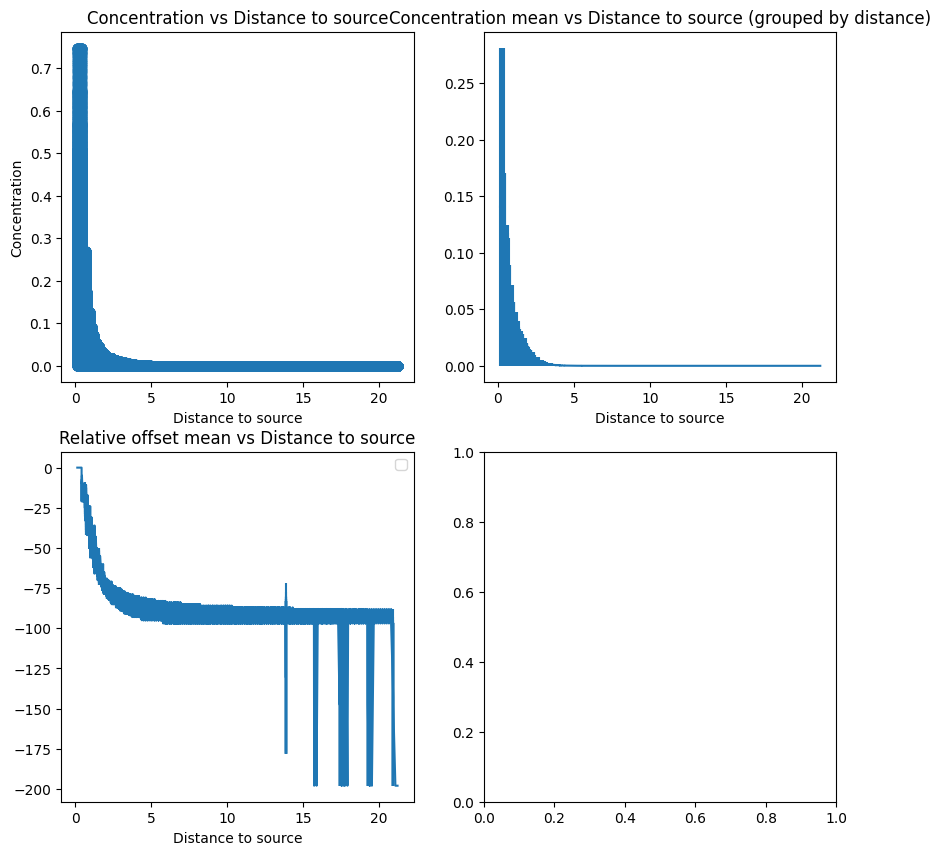

In [147]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].scatter(data["distances_to_source"], data["values"])
axes[0, 0].set_xlabel("Distance to source")
axes[0, 0].set_ylabel("Concentration")
axes[0, 0].set_title("Concentration vs Distance to source")

distance_group = data.groupby("distances_to_source")

distance_group_mean = distance_group.mean()
distance_group_std = distance_group.std()

axes[0, 1].errorbar(distance_group_std.index, distance_group_std["values"], yerr=distance_group_std["values"])
axes[0, 1].set_xlabel("Distance to source")
axes[0, 1].set_title("Concentration mean vs Distance to source (grouped by distance)")

diffusion_coefficient_group = data.groupby(["distances_to_source", "diffusion_coefficients"])

diffusion_coefficient_group_mean = diffusion_coefficient_group.mean()
diffusion_coefficient_group_std = diffusion_coefficient_group.std()

axes[1, 0].errorbar(diffusion_coefficient_group_mean.index.get_level_values(0), diffusion_coefficient_group_mean["relative_offsets"], yerr=diffusion_coefficient_group_std["relative_offsets"])
axes[1, 0].set_xlabel("Distance to source")
axes[1, 0].set_title("Relative offset mean vs Distance to source")
axes[1, 0].legend()


Let's plot the correlation matrix to see if there are any obvious relationships between the columns.

([<matplotlib.axis.XTick at 0x7f11054bb990>,
 [Text(0, 0, 'diffusion_coefficients'),
  Text(1, 0, 'x'),
  Text(2, 0, 'y'),
  Text(3, 0, 'time'),
  Text(4, 0, 'values'),
  Text(5, 0, 'distances_to_source'),
  Text(6, 0, 'relative_offsets'),
  Text(7, 0, 'source_positions_x'),
  Text(8, 0, 'source_positions_y'),
  Text(9, 0, 'mean'),
  Text(10, 0, 'std')])

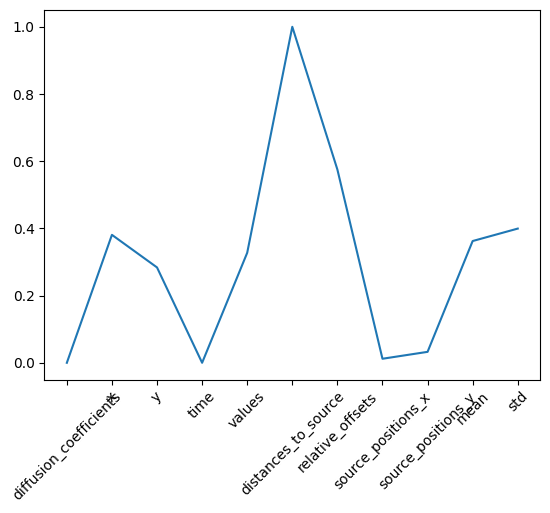

In [148]:
grouped_data = data
grouped_data["mean"] = data.groupby(["distances_to_source", "diffusion_coefficients", "source_positions_x", "source_positions_y"])["values"].transform('mean')
grouped_data["std"] = data.groupby(["distances_to_source", "diffusion_coefficients", "source_positions_x", "source_positions_y"])["values"].transform('std')

plt.plot(np.abs(grouped_data.corrwith(grouped_data["distances_to_source"])))
plt.xticks(range(len(grouped_data.columns)), grouped_data.columns, rotation=45)

Let's train a model to predict the distance to the target based on the data.

1. Define the target variable and the features

In [149]:
x = grouped_data[["x", "y", "relative_offsets", "mean", "std"]]

y = data["distances_to_source"]

2. Normalize the input data for better performance

In [150]:
scaler = StandardScaler()

x = scaler.fit_transform(x)

1. Prepare a k-fold cross-validation

In [151]:
fold = KFold(n_splits=5, shuffle=True, random_state=42)

1. Prepare the tensorflow keras model from the data

In [152]:
def create_model():
    # Configure tensorflow to use 20 threads
    os.environ["OMP_NUM_THREADS"] = "20"

    tf.config.threading.set_inter_op_parallelism_threads(20) 
    tf.config.threading.set_intra_op_parallelism_threads(20)
    tf.config.set_soft_device_placement(True)

    # Create a model
    model = Sequential([
        Dense(256, activation='relu', input_shape=(5,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

model = create_model()

/home/alix_anneraud/.python_environment/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6. Set the early stopping callback

In [153]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

5. Train the model

In [154]:
def train_model(model, x, y, fold, early_stopping, epochs=100):
    n_splits = fold.get_n_splits()

    for i, (train_index, test_index) in enumerate(fold.split(x)):
        print(f"Training with fold {i + 1} in {n_splits} (train size: {len(train_index)}, test size: {len(test_index)})")
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]


        batch_size = (x_train.nbytes + y_train.nbytes) // 2


        print(f"Batch size: {batch_size}")

        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[early_stopping])

train_model(model, x, y, fold, early_stopping)

Training with fold 1 in 5 (train size: 3279520, test size: 819880)
Batch size: 78708480
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 116.5465 - val_loss: 114.3256
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 114.2153 - val_loss: 112.4324
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 112.3239 - val_loss: 110.5523
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 110.4456 - val_loss: 108.6076
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 108.5028 - val_loss: 106.5841
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 106.4811 - val_loss: 104.3792
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 104.2780 - val_loss: 101.9559
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 101.8567 - val_loss: 99.3316
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 99.2346 - val_loss: 96.4962
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 96.4017 - val_loss: 93.4082
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss:

6. Save the model and the scaler to disk

In [ ]:
# Save the model to disk
model.save("model.keras")
# Save the scaler to disk
dump(StandardScaler(), open("scaler.pkl", "wb"))

Let's plot the error of the model depending on the distance to the target and the diffusion coefficient.

In [ ]:
predictions = model.predict(x, batch_size=16777216)

error = np.abs(predictions.flatten() - data["distances_to_source"])

prediction_data = pd.DataFrame({
    "distances_to_source": data["distances_to_source"],
    "predictions": predictions.flatten(),
    "diffusion_coefficients": data["diffusion_coefficients"],
    "error": error
})


grouped = prediction_data.groupby("distances_to_source")

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

mean = grouped.mean()
std = grouped.std()
median = grouped.median()

axes[0].errorbar(mean.index, mean["error"], yerr=std["error"], fmt='o', label="Mean")
axes[0].scatter(median.index, median["error"], label="Median", color="red", marker="_")
axes[0].set_xlabel("Distance to source")
axes[0].set_ylabel("Mean absolute error")
axes[0].set_title("Mean absolute error vs Distance to source")
axes[0].legend()

grouped = prediction_data.groupby("diffusion_coefficients")

mean = grouped.mean()
std = grouped.std()
median = grouped.median()

axes[1].errorbar(mean.index, mean["error"], yerr=std["error"], fmt='o', label="Mean")
axes[1].scatter(median.index, median["error"], label="Median", color="red", marker="_")
axes[1].set_xlabel("Diffusion coefficient")
axes[1].set_ylabel("Mean absolute error")
axes[1].set_title("Mean absolute error vs Diffusion coefficient")
axes[1].legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


ValueError: operands could not be broadcast together with shapes (20600,) (4099400,) 